Copyright 2022 Giorgia Sampò <giorgia.sampo@studio.unibo.it>, Davide Brembilla <davide.brembilla@studio.unibo.it>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# RedditHoles - A study in  internet Rabbit Holes

## An introduction to Reddit

Reddit is a social media platform organised in communities, rather than individual connections. This makes the experience on the platform quite different from other Social Networks and closer, in a way, to the one of forums.  
This is the source material for the website [RedditHoles](https://dbrembilla.github.io/redditholes/). We advise you to take a look at it before examining our code. If you find issues, please update an issue on Github.

### u_User / u/User
A user (also called redditor, usually referred as “u/” followed by the username) can make a post (also called a submission); posts (also called submissions) can be links, videos, pictures, polls or text. The OP (Original Poster) as well as other users can comment and vote (either upvote or downvote) the post if they find it interesting (so it’s not exactly like like/dislike features of other Social Networks). Finally, users can give posts awards by paying for reddit coins; these recognise the contributions of a post or comment. There are hundreds of these, from a generic gold or silver award to some following internet lingo, such as the “F” award (used ironically to ‘pay respect’). 

Users can mark their posts as spoilers and multiple types of flairs and markings such as OC (Original Content), Spoilers, +18 and so on. Some subreddits might have rules for posting. 

Users can be humans or bots. Bots have multiple uses, from auto moderation, to answering with quotes from movies and books, waving flags to other utilities and fun uses. 
#### The average redditor

Reddit users, according to [data from the site itself](https://www.redditinc.com/advertising/audience), are more than 50 million with more than 100 thousand communities. They are mostly male (56%) and have between 18 and 34 year old (58%). 

### r/Subreddits

Reddit is structured in subreddits, communities that group in various ways the interested users. Subreddits can vary from cute pets, to political parties, to recipe advice. Subreddits are usually referred to as “r/” followed by the name of the subreddits (in our case, we will study “r/conspiracy” and related subreddits). 

Subreddits can vary significantly. They can have rules for posting, different levels of moderation and bot acceptance, all depending from the nature of the subreddit. Rules of subreddits can have different nature; some subreddits may require the content of a post to be marked, some require sources to be linked, some can have no rules at all. This ambiguity makes Reddit a much more decentralised and open Social Network in which some of the cut down on fake news and trolls which happened on sites such as Facebook or Twitter has not yet happened at the same level. 



## Accessing Reddit Data
In order to access data from the Reddit API, we used the [`praw` python library](https://github.com/praw-dev/praw). 
In order to use that, we need:
- a Reddit account.
- a Reddit app ([here](https://www.reddit.com/prefs/apps) you can create one). You will find the client id under the app name once you create it, as well as the client secret and the user agent, which is your app name.

Once we have those, we can access Reddit by creating a Reddit instance in praw (it is also possible to access as a user by adding username and account if you want to use it in write mode, meaning you can post from the terminal if you so choose).

In [ ]:
#!pip install praw
#!pip install pandas
import praw
reddit = praw.Reddit(client_id = "my_client", client_secret= "my_secret", user_agent= "my_user_agent")

Now we can access information about subreddits, posts and users. As an example, we can access the top 5 posts of all time on Reddit, with the information about the author and the upvote ratio and date (in UTC format):

In [ ]:
for i in reddit.subreddit('all').top(limit=5): #this will print the top posts all time
    print(i.title + ' Author: ' + i.author.name +  ' Link: https://www.reddit.com' + i.permalink + ' Subreddit: r/' + i.subreddit.display_name + ' Upvote Ratio: ' + str(i.upvote_ratio) + ' Date (UTC Format): '+str(i.created_utc))

## Scraping Reddit, starting from r/conspiracy

Our objective is to watch how a piece of news or a post is shared between different subreddits. While most social network would measure shares of a post, Reddit is built in a way that if a link is shared in the platform, it is possible to retrieve how much the original link is shared through subreddits. As an example, if an image from imgur is shared, we can use its url to search for the same object on Reddit.
This happens because, for the most part, Reddit is used to comment news and multimedia in communities, which often present a common worldview (e.g. subbreddits made by people with same political views).
We started with the [r/conspiracy](https://www.reddit.com/r/conspiracy/)'s posts, in particular the top 5000 posts all time. We opted for the top posts all time because the other types of ranking are time-bound and we wanted to watch the overall transmission of posts.
Please keep in mind that your results may be different than ours; we scraped Reddit between February and April 2022.

In [ ]:
import pandas as pd
post_list=list()
subreddit_list = list()
conspiracy_dict=dict()

for i in reddit.subreddit("conspiracy").top(limit=5000): 
    post_list.append(i.url) # This may seem counterintuitive, but in praw's terms this is the original link of the resource inside the post.


for post in post_list:
    for repost in reddit.subreddit('all').search('url:'+post): # This function searches for the original post's element
        subreddit_url = str(repost.subreddit)
        if subreddit_url =='conspiracy':
            continue
        subreddit_url = "https://www.reddit.com/r/" + subreddit_url
        if subreddit_url in conspiracy_dict.keys():
            conspiracy_dict[subreddit_url][0].append("https://www.reddit.com"+repost.permalink)
            conspiracy_dict[subreddit_url][1][0] +=1
        else:
            conspiracy_dict[subreddit_url]=[[],[1]]
            conspiracy_dict[subreddit_url][0].append("https://www.reddit.com"+repost.permalink)
            
                


df = pd.DataFrame(conspiracy_dict)
df.to_csv(r'results/conspiracy_data/conspiracy.csv',index=False)




We realised after the fact that this method also got the reposts inside the same subreddit. After manually cleaning the csv in this instance, we proceeded to remove this problem in the following steps.

### Creating a network of subreddits

After scraping r/conspiracy, we moved to the neighbouring subreddits. What this will do is creating a network of shared posts between subreddits.

First we need to look at all the files in the directory. We built this function to easily get all the csv files easily.

In [2]:
def get_all_in_dir(dir):
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        if os.path.isfile(f) and f[-4:] == ".csv":
            yield f

Now we can scrape the other subreddits that had more than 5 posts in common with r/conspiracy.

In [ ]:
df1 = pd.read_csv('results/conspiracy_data/conspiracy.csv')
id_to_analyse = []
 # We iterate over the csv columns to see all the informations in them, selecting only the subreddits with more than 5 posts in common
for column in df1.columns:
    value = df1[column][1][1:-1]
    if int(value) >= 5:
        ind = column.index('/r/')
        id = column[ind+3:]
        id_to_analyse.append(id)
        

for subreddit in id_to_analyse:
    post_list=list()
    subreddit_list = list()
    conspiracy_dict=dict() 
    for i in reddit.subreddit(subreddit).top(limit=5000):
        post_list.append((i.title, i.score, i.url))



    for post in post_list:
        for repost in reddit.subreddit('all').search('url:'+post[2]):
            if repost.subreddit_id != "t5_"+reddit.subreddit(subreddit).id: # avoid reposts
                subreddit_url = str(repost.subreddit)
                subreddit_url = "https://www.reddit.com/r/" + subreddit_url
                if subreddit_url in conspiracy_dict.keys():
                    conspiracy_dict[subreddit_url][0].append("https://www.reddit.com"+repost.permalink)
                    conspiracy_dict[subreddit_url][1][0] +=1
                else:
                    conspiracy_dict[subreddit_url]=[[],[1]]
                    conspiracy_dict[subreddit_url][0].append("https://www.reddit.com"+repost.permalink)
    df = pd.DataFrame(conspiracy_dict)
    df.to_csv(r'results/1st_level/'+subreddit+'.csv')

We repeat the cycle one more time, but this time with just the top 500 posts, in order to speed up the process.

In [ ]:
import pandas as pd
top_comments_list = dict()
to_scan = [file for file in get_all_in_dir("results/1st_level_2")]
to_avoid= [file.split('\\')[1] for file in get_all_in_dir("results/1st_level")]
# To separate the load of scraping between two computers and not repeat scraping for existing subreddits, we divided the 1st level \\
# in two separate folders.
# to_avoid.extend(file.split('\\')[1] for file in get_all_in_dir("results/1st_level_2"))
# to_avoid.extend(file.split('\\')[1] for file in get_all_in_dir("results/2nd_level"))

for subr in to_scan:
        id_to_analyse = []
        print(f'now opening {subr}')
        try:
                df1 = pd.read_csv(subr)
        except:
                pass
        try:
                df1 = pd.read_csv(subr, encoding='utf8')
        except:
                print(f'unable to open {subr}')
                continue
        for column in df1.columns:
                try: 
                        value = df1[column][1][1:-1]
                except:
                        continue
                if int(value) >= 5:
                        ind = column.index('/r/')
                        id = column[ind+3:]
                        if not id + '.csv' in to_avoid:
                                try:
                                        post_list=list()
                                        subreddit_list = list()
                                        conspiracy_dict=dict() 
                                        for i in reddit.subreddit(id).top(limit=500):
                                                post_list.append((i.title, i.score, i.url))

                                        for post in post_list:
                                                for repost in reddit.subreddit('all').search('url:'+post[2]):
                                                        if repost.subreddit_id != "t5_"+reddit.subreddit(id).id: #cosa facciamo?
                                                                subreddit_url = str(repost.subreddit)
                                                                subreddit_url = "https://www.reddit.com/r/" + subreddit_url
                                                        else:
                                                                continue
                                                        if subreddit_url in conspiracy_dict.keys():
                                                                conspiracy_dict[subreddit_url][0].append("https://www.reddit.com"+repost.permalink)
                                                                conspiracy_dict[subreddit_url][1][0] +=1
                                                        else:
                                                                conspiracy_dict[subreddit_url]=[[],[1]]
                                                                conspiracy_dict[subreddit_url][0].append("https://www.reddit.com"+repost.permalink)
                                        
                                        df = pd.DataFrame(conspiracy_dict)
                                        df.to_csv(r'results/2nd_level/'+id+'.csv')
                                        with open("results/2nd_level/done_2.txt",'a', encoding = "utf-8") as text_note:
                                                text_note.write(id + "\n")
                                                text_note.close()
                                        
                                except Exception as E:
                                        print(E)
                                        with open("results/2nd_level/error_2.txt",'a', encoding = "utf-8") as text_note:
                                                text_note.write(id + "\n")
                                                text_note.close()
                                

## Cleaning the data
In order to perform more efficiently the operations of data representation we decided two perform two operations:
1. We turned the number of crossposts into integers.
2. We removed subreddits with less than 5 posts in common.
We did this in order to have cleaner and easier to use data.

In [ ]:
#removing parentheses and connections with less than 5 reposts
import pandas as pd
datasets= [file for file in get_all_in_dir("results/1st_level")]
datasets.extend(file for file in get_all_in_dir("results/1st_level_2"))
datasets.extend(file for file in get_all_in_dir("results/2nd_level"))
datasets.extend("results/conspiracy_data/conspiracy_top_url.csv")

for file in datasets:
    try:
        df = pd.read_csv(file, sep=',', on_bad_lines='skip', encoding='utf8')
    except:
        pass
    try:
        df = pd.read_csv(file, on_bad_lines='skip', encoding='latin')
    except Exception as e:
        print(e)
        print(file, 'has problems in formatting')
        continue
    for col in df.columns:
        if "u/" in col or 'u_' in col: #Sometimes users end up in the columns. Remove them. 
            df.drop(col, inplace=True, axis=1)
        else:
            try:
                
               if isinstance(df[col][1], str): 
                    try:
                        df[col][1]=int(df[col][1][1:-1])
                    except:
                        continue
                    if df[col][1]<5:
                        df.drop(col, inplace=True, axis=1)
            except:
                df.drop(col, inplace=True, axis=1)
    df.to_csv(file, encoding="utf8")
        

Given the data from Reddit, we can build a network of shared posts.

### Building the Network of crossposts
By using Gephi, we plotted the network of crosspost. By doing this, we found some communities of subreddits that present a significant number of crossposts.
1. <b>Crypto, Tech and other news</b>, with a part dedicated to tech (BitcoinAll, Mistifront, Libertarian, Technews and brprogramming) and another about politics and conspiracies (conspiracy, politics...).
2. <b>MetaReddit</b>, subreddits that share a meta-reddit approach (e.g. bots collecting stories from everywhere or comments about reddit), that are also very interlinked with generalist subreddits (such as r/pics). Among these are mistyfront, SubredditNN, Blackout2015. This is very intelinked with tech and general politics.  
3. <b>Politics/News</b> with various news and political subreddits, from either party or with no party affiliation, but also with a significant conspiracy news subgroups. Among these are anythingGoesNews, ConspiracyII, Coronavirus, infrasociology
4. <b>Leftist Politics</b> centred around WayOfTheBern, LateStageCapitalism, SocialismAndVeganism, but also TrueReddit.
5. <b>Bernie Sanders</b> - Started from StillSandersForPresident, WayOfTheBern, RealBlueMidterm (central to other minor subreddits) A significant group of subreddits all sharing the topic of popularising the figure of Bernie Sanders. The main gateways seem to be NEwYorkSanders,FLoridaforSanders ad CaliforniaFOrSanders.
6. <b>Conservative/Libertarian</b> subreddits from the right and alt-right, with Conservative, Libertarian, Descent into tyranny but also  news sources such as Worldpolitics and alternative news subreddits such as Censorship 
7. <b>Science and Pseudoscience</b>, subreddits discussing both scientific news(environment, AutoNewspaper), views of the future(futurology) but also pseudoscience (ScienceUncensored, DebateVaccines)
8. <b>Information</b> a subnetwork connected both to general information subreddits (todayilearned) and classified.

In [ ]:
#Build the network
datasets= [file for file in get_all_in_dir("results/1st_level")]
datasets.extend(file for file in get_all_in_dir("results/1st_level_2"))
datasets.extend(file for file in get_all_in_dir("results/2nd_level"))

network_list = list()

for subr in datasets:
        #print(f'now opening {subr}')
        try:
                df1 = pd.read_csv(subr)
        except:
                pass
        try:
                df1 = pd.read_csv(subr, encoding='utf8')
        except:
                print(f'unable to open {subr}')
                continue
        sub_name=subr[subr.find("\\")+1:-4]
        for column in df1.columns:
                try: 
                        value = column
                except:
                        continue
                if column [:7] != "Unnamed":
                        col_name = column[column.find("/r/")+3:]
                        try:
                                network_list.append((sub_name, col_name, df1[column][1]))
                        except Exception as E:
                                print(E) 
                else: 
                        continue
print(network_list)

'''' with open('Network.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(["Source", "Target", "Weight"])
    write.writerows(network_list)'''

## Analysing the comments
A part of our inquiry involves the kind of language that redditors use on the website in response to posts. In order to this, we employed two techniques that allow us to find out the nature of a text: Topic Modelling and Sentiment Analysis

### Topic modelling
Topic modelling is a machine learning technique that tries to predict the distribution of abstract topics in a text, and thus reveal the hidden semantic structures within it. In particular, we used Latent Dirichlet Allocation (LDA) method. We adapted the method used in [here](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction).
The libraries used are <code>[nltk](https://www.nltk.org/), [gensim](https://github.com/RaRe-Technologies/gensim/), [spacy](https://spacy.io/), [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html)</code>.

Since the number of comments can be particularly big, we used this code snippet to get a random sample from bigger comment sections.

In [3]:
import random
def iterSample(iterable, samplesize):
    results = []
    for i, v in enumerate(iterable):
        r = random.randint(0, i)
        if r < samplesize:
            if i < samplesize:
                results.insert(r, v) # add first samplesize items in random order
            else:
                results[r] = v # at a decreasing rate, replace random items


    return results

Here we import the dataset and the comments from the posts in common between subreddits.

In [ ]:
import pandas as pd
import re
to_scan= [file for file in get_all_in_dir("results/subnetworks")]
for subreddit in to_scan:
        comment_dict = dict()
        print('Opening', subreddit)
        try: 

                df = pd.read_csv(subreddit, encoding='utf8', on_bad_lines='skip')
                
                if os.path.isfile('comments_'+subreddit.split('\\')[1]):
                        start = (pd.read_csv('comments_'+subreddit.split('\\')[1])['Source'].iloc[-1], pd.read_csv('comments_'+subreddit.split('\\')[1])['Target'].iloc[-1])
                        start= int(df.loc[(df['Source'] == start[0]) & (df['Target'] == start[1])].index[0])
                        if start >= len(df):
                                continue        
                        df = df[start+1:].dropna()
        except Exception as e:
               print('error',e,subreddit)
               continue
                
        for row in df.to_dict(orient='records'):
                if isinstance(row['Source'], float) or isinstance(row['Target'],float):
                        continue
                if 'https' in row['Source'] or 'https' in row['Target']:
                        continue
                try:
                        list_post= row['Posts'][1:-1].split(',')
                except Exception as e:
                        continue
                result = ''
                num = 0
                for post_url in list_post:
                        if post_url == 0:
                                continue
                        post_url = post_url.replace(' ','')
                        #tmp =  re.sub("\[\]\'", "", post_url) NON FUNZIONA E NON CAPISCO PERCHé
                        if post_url[1:-1] in comment_dict.keys():
                                result += comment_dict[post_url[1:-1]][0]
                                num += comment_dict[post_url[1:-1]][1]
                                continue
                        try:
                                post = reddit.submission(url=post_url[1:-1])
                                try:
                                        #This allows up to 1 reply to each post.
                                        post.comments.replace_more(limit=1)
                                except Exception as e:
                                        print(e)
                                        print(f'{post}s comments was not accessible')
                                        continue
                                num += len(post.comments)
                                this_comment = ''
                                if num > 500:
                                        for comment in iterSample(post.comments, 500):
                                                try:
                                                        this_comment += comment.body
                                                        for reply in comment.replies:
                                                                this_comment+= reply.body
                                                        this_comment=this_comment.replace(',','')
                                                        this_comment=this_comment.replace('\n','\s')
                                                except Exception as e:
                                                        print(e)
                                                        continue
                                else:
                                        for comment in post.comments:
                                                try:
                                                        this_comment += comment.body
                                                        for reply in comment.replies:
                                                                this_comment+= reply.body
                                                        this_comment=this_comment.replace(',','')
                                                        this_comment=this_comment.replace('\n','\s')

                                                except Exception as e:
                                                        print(e)
                                                        continue
                                comment_dict[post_url[1:-1]] = (this_comment,num)
                                result += this_comment
                        except Exception as e:
                                print(e)
                                print(post.permalink + ' is not accessible')
                                continue                                         
                res=pd.DataFrame.from_dict([{'Source':row['Source'], 'Target':row['Target'],'NumberComments': num,'Comments':result}])
                if os.path.isfile('comments_'+subreddit.split('\\')[1]):
                        res.to_csv('comments_'+subreddit.split('\\')[1],  encoding='utf8', mode='a', header=False)
                else:
                        res.to_csv('comments_'+subreddit.split('\\')[1],  encoding='utf8')
                        
        print(subreddit, ' is finished')
                        
                        

We can now perform the 
### Topic modeling
First we need to define the functions.

In [7]:
#!pip install nltk
#!pip install gensim
#!pip install spacy
#!pip install pyLDAvis
import nltk
nltk.download('stopwords')
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['re', 'edit','http\_np', 'autotldr\_pm', 'autotldr\_comment', 'version\_tl', 'comment\_fm', 'thing', 'com']) 

import re
import os
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as genmodels  # don't skip this
import matplotlib.pyplot as plt

import warnings
#python -m spacy download en_core_web_sm
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


We can now print a csv for each subnetwork identified, containing the topic modeling of the common posts.

In [11]:
to_topic = [file for file in get_all_in_dir('comments')] #inserire iterazione su tutti i csv


In [10]:
def topic_model(corpus, id2word):
    if corpus != [] and corpus != [[]] and corpus!=[[[]]]:
        try:
            # Build LDA model
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=5, 
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='symmetric',
                                                    per_word_topics=True)

            # Print the Keyword in the 10 topics
            topics = {}
            list_topics=lda_model.print_topics(num_words=5)
            for topic in list_topics:
                topics[topic[0]] = topic[1].split(" + ")
            out = pd.DataFrame(topics)
            return out
        except Exception as e:
            return []


In [12]:
avoid=set()
first = True
for file in to_topic:
    if file in avoid:
        continue
    df = pd.read_csv(file, encoding = 'utf8')
    if any(char.isdigit() for char in file):
        filename = file.split('\\')[1]
        filename = re.sub('\d|\.csv', '', filename)
        for el in to_scan:
            if filename in el:
                avoid.add(el)
                df = df.append(pd.read_csv(el, encoding="utf-8")) #mmodificato 01/05 ore 20:10
                if first:
                    df.to_csv('test.csv')
    else:
        continue # Da  togliere, 01/05 errore somme csv con numeri
                

    df = df.astype(str)

    comments = df["Comments"]
    
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in comments]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    # Tokenizing the text
    data_words = list(sent_to_words(data))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    for i in range(len(data_words_bigrams)):
        el=data_words_bigrams[i]
        if len(el)>=100000:#avoid inputs larger than 1000000 by random sampling them\
            data_words_bigrams[i] = iterSample(el, 100000)
            

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Human readable format of corpus (term-frequency)
    [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

    out = topic_model(corpus, id2word)
    out.to_csv("topic_modeling_"+ file.split("\\")[1])

WE can now plot graphs using the topic models obtained

In [ ]:
to_plot = [file for file in get_all_in_dir('topics')] #inserire iterazione su tutti i csv
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
import matplotlib, random

hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []
for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)

In [ ]:

for file in to_plot:
    topics = pd.read_csv(file, encoding="utf-8")
    topics = topics.drop("Unnamed: 0", axis=1)
    topics = topics.astype(str)
    #print(topics.head())
    path = file[:-4] + '_html.html'
    out = []
    
    topics=topics["0"]
    for topic in topics:
        topic = topic.replace('"', "")
        topic = topic.split('*')
        weight = float(topic[0])
        if weight<=0.000:
            weight=0.001
        out.append([topic[1], weight])

    df = pd.DataFrame(out, columns=['word', 'importance']) 
    my_layout = go.Layout({"title": "Main Topic",
                       "yaxis": {"title":"Importance"},
                       "xaxis": {"title":"Word"},
                       "showlegend": False}) 
    fig = px.bar(df, x='word', y = 'importance', range_color = random.choice(hex_colors_only), color='word')
    fig.update_layout(my_layout)
    fig.update_xaxes(tickangle = 45)
    fig.write_html(path)
    
    



### Wordclouds
Another interesting visualization related to topics inside the text is the one of WordClouds or Tag Clouds.<br>
After analyzing again the comments CSVs we can process them and understand word frequencies.<br>
We can then proceed to properly represent them as word clouds, be the employment of <a href= "https://amueller.github.io/word_cloud/">Wordcloud</a>.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
to_tagcloud = [file for file in get_all_in_dir('comments')] #inserire iterazione su tutti i csv
to_tagcloud.sort(reverse=True)

In [5]:
import multidict as multidict
import random

import numpy as np

import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match('a|the|an|the|to|in|for|of|or|by|with|is|on|that|be|it\.|http|thing|1|2|3|4|5|6|7|8|9|0|bot|than|;|&|tl;drs|-|>|out\.', text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def makeImage(text, path):
    img_path = "assets/img/alice_mask_1.png"
    alice_mask = np.array(Image.open(img_path))
    

    wc = WordCloud(background_color=None, mode="RGBA", max_words=1000, mask=alice_mask)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("png_"+path+'.png', format="png", dpi=1200)
    plt.show()
    



C:\Users\Giorgia Sampo\AppData\Local\Temp\ipykernel_6264\3402088887.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(el, encoding="utf-8"))
C:\Users\Giorgia Sampo\AppData\Local\Temp\ipykernel_6264\3402088887.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(el, encoding="utf-8"))


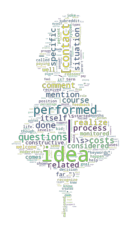

C:\Users\Giorgia Sampo\AppData\Local\Temp\ipykernel_6264\3402088887.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(el, encoding="utf-8"))
C:\Users\Giorgia Sampo\AppData\Local\Temp\ipykernel_6264\3402088887.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(el, encoding="utf-8"))
C:\Users\Giorgia Sampo\AppData\Local\Temp\ipykernel_6264\3402088887.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(el, encoding="utf-8"))
C:\Users\Giorgia Sampo\AppData\Local\Temp\ipykernel_6264\3402088887.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.ap

In [6]:
# Prep TF-IDF Matrix for Word Clouds
avoid=set()
for file in to_tagcloud:
    if file in avoid:
        continue
    df = pd.read_csv(file, encoding = 'utf8')
    if any(char.isdigit() for char in file): # Modificato 01/05
        filename = file.split('\\')[1]
        filename = re.sub('\d|\.csv', '', filename)
        for el in to_tagcloud:
            if filename in el:
                avoid.add(el)
                df = df.append(pd.read_csv(el, encoding="utf-8"))
    else:
        continue #Inserito 01/05 per errore numeri, da eliminare


    df = df.astype(str)
    text = df.sum()["Comments"]
    name_image=file.split("\\")[1][:-4]
    makeImage(getFrequencyDictForText(text), name_image)
    
    

### Sentiment Analysis
Sentiment analysis is the computational study of people's emotions expressed in text. In our case we used the popular VADER sentiment analyser, an analyser especially created for social networks (in particular, it was based off Twitter). The result of each comment's analysis will be a number between -1 and 1, depending on whether the comment is perceived as negative or positive.

In [2]:
to_scan = [file for file in get_all_in_dir('comments')] 

In [5]:
import pandas as pd
import re
avoid = set()
for file in to_scan:
    if file in avoid:
        continue
    df = pd.read_csv(file, encoding='utf8')
    if any(char.isdigit() for char in file): # PASSAGGIO 1
        filename = file.split('\\')[1]
        filename = re.sub('\d|\.csv', '', filename)
        for el in to_scan:
            if filename in el:
                avoid.add(el)
                to_add = pd.read_csv(el, encoding='utf8')
                df = df.append(to_add, ignore_index=True)


    heat = pd.DataFrame(columns = ['Index'])
    targets = set(df['Target'])
    to_add = {}
    for column in targets:
        if isinstance(column, float):
            continue
        if 'https' in column or '/' in column:
            continue
        with_target=df[df['Target']==column]
        for row in with_target.to_dict(orient='records'):
            to_add = {}
            if row['Source'] not in heat['Index'].values:
                to_add[column] = row['Comments']
                to_add['Index'] = row["Source"] 
                heat = heat.append(to_add, ignore_index=True)
            else:
                position = row['Source']
                position = heat[heat["Index"]==position].index
                heat.at[position, column] = row['Comments']
    heat.to_csv('heat\\heat_'+file.split('\\')[1], encoding='utf8')

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [3]:
to_sent = [file for file in get_all_in_dir('heat')]

In [5]:
import nltk 
import pandas as pd
#nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()


In [6]:
import numpy as np
for file in to_sent:
    if not any(char.isdigit() for char in file): # PASSAGGIO 2
        continue
    df = pd.read_csv(file, encoding = 'utf8')
    df=df.set_index("Index")
    iterator = df.to_dict(orient='index')
    for sub in iterator.keys():
        for key in iterator[sub].keys():
            if isinstance(iterator[sub][key], str):
                df.at[sub, key] = sent.polarity_scores(iterator[sub][key])['compound']
    df.to_csv('map' + file.split('\\')[1], encoding='utf8')


KeyboardInterrupt: 

In [ ]:
import plotly.express as px
import  matplotlib.pyplot as plt
import pandas as pd
for data in get_all_in_dir('map'):
    path = data.split('.')[0]+'_html.html'
    df = pd.read_csv(data, encoding='utf8').drop('Unnamed: 0', axis=1)
    df = df.set_index('Index')
    df.index.rename('', inplace=True)
    height = 800
    if len(df.index) < 7:
        height = 400
    fig = px.imshow(df, height=height, width=1024, color_continuous_scale=['red','yellow','green'], aspect='auto',x=df.columns,y=df.index)
    fig.update_xaxes(tickangle = 90)
    fig.write_html(path)


# Per plottare con pandas etc: inverti colonna, rendi int, droppa colonne inutili, and go.

[vedi qui](https://stackabuse.com/rotate-axis-labels-in-matplotlib/)

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
import plotly.express as px

to_plot = get_all_in_dir('results')
for i in to_plot:
    df1 = pd.read_csv(i)
    df2 = pd.read_csv(i)
    path_src = i.split('.')[0]+'_src_html.html'
    path_tar = i.split('.')[0]+'_tar_html.html'
    to_drop = [i for i in df1.columns if i not in ['Source','Target','Weight']]
    
    df1 = pd.read_csv(i).drop(to_drop, axis=1)
    df1 = df1.set_index('Source')
    df2 = pd.read_csv(i).drop(to_drop, axis=1)
    df2 = df2.set_index('Target')
    df1 = df1.groupby("Source").sum()
    df2 = df2.groupby("Target").sum()
    
    fig = px.bar(df1['Weight'].nlargest(n=20))
    fig.update_xaxes(tickangle = 90)
    fig.write_html(path_src)
    fig = px.bar(df2['Weight'].nlargest(n=20))
    fig.update_xaxes(tickangle = 90)
    fig.write_html(path_tar)
